# **Aprovação de Crédito**
## Regressão Logística

#### Código: Python
 
___

Objetivos:
- Solucionar problemas de classificação;
- Manipular e analisar variáveis reais;
- Explorar e adequar dados para modelos matemáticos;
- Avaliar e otimizar o modelo.

### 
___

## 1 BIBLIOTECAS

In [1]:
# Manipulação de dados
import math
import numpy as np
import pandas as pd

# Visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

# Modelagem matemática
import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

## 2 OBTENDO  E TRATANDO DADOS

In [2]:
# Fonte da base de dados
source = 'https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data'

# Cria nomes para as variáveis
names = []
for i in range(15):
    names.append('A' + str(i + 1))
names.append('target')

# Lê e apresenta os dados
data = pd.read_table(source, sep=',', header = None, names = names)
data

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,target
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,b,21.08,10.085,y,p,e,h,1.25,f,f,0,f,g,00260,0,-
686,a,22.67,0.750,u,g,c,v,2.00,f,t,2,t,g,00200,394,-
687,a,25.25,13.500,y,p,ff,ff,2.00,f,t,1,t,g,00200,1,-
688,b,17.92,0.205,u,g,aa,v,0.04,f,f,0,f,g,00280,750,-


In [3]:
# Elimina variáveis indesejadas
data = data.drop(['A4', 'A5', 'A14'], axis = 1)

### 2.1 Tratamento dos dados

In [4]:
# Busca por valores nulos e faltantes
print(data.isna().values.any())
print(data.isnull().values.any())

False
False


In [5]:
# Identificando característica do valor faltante através de A1
print(data['A1'].unique())
print('\n')

# Verificando quantidade de faltantes por variáveis
print(data['A1'].value_counts()['?'])
print(data['A2'].value_counts()['?'])
print(data['A6'].value_counts()['?'])
print(data['A7'].value_counts()['?'])

['b' 'a' '?']


12
12
9
9


In [6]:
# Substituindo '?' por NaN
data = data.replace("?",np.NaN)

print(data.isna().values.any())
print(data.isnull().values.any())

# Tratando os valores faltantes
data = data.fillna(method = 'ffill')

print(data.isna().values.any())
print(data.isnull().values.any())

True
True
False
False


## 3 EXPLORAÇÃO E ADEQUAÇÃO DE VARIÁVEIS (Feature engineering)

In [7]:
df = data.copy()

# Verificando tipos de dados
df.dtypes

A1         object
A2         object
A3        float64
A6         object
A7         object
A8        float64
A9         object
A10        object
A11         int64
A12        object
A13        object
A15         int64
target     object
dtype: object

In [8]:
# Corrigindo variáveis contínuas para tipo numérico
df.A2 = pd.to_numeric(df.A2)

# Estatística descritiva dos dados
df.describe()

,A2,A3,A8,A11,A15
count,690.000000,690.000000,690.000000,690.00000,690.000000
mean,31.483058,4.758725,2.223406,2.40000,1017.385507
std,11.912872,4.978163,3.346513,4.86294,5210.102598
min,13.750000,0.000000,0.000000,0.00000,0.000000
25%,22.580000,1.000000,0.165000,0.00000,0.000000
50%,28.375000,2.750000,1.000000,0.00000,5.000000
75%,37.750000,7.207500,2.625000,3.00000,395.500000
max,80.250000,28.000000,28.500000,67.00000,100000.000000


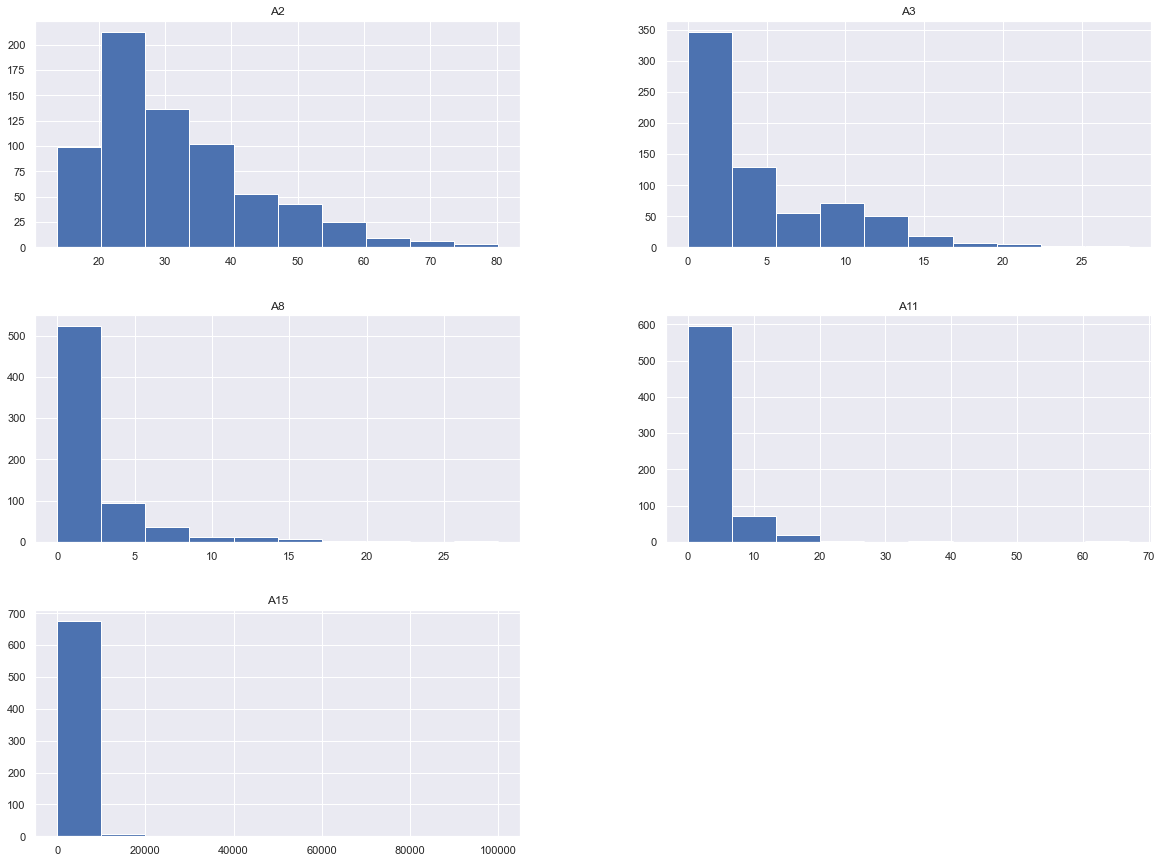

In [9]:
# Observa a distribuição de dados contínuos
df.hist()
plt.gcf().set_size_inches(20, 15)

In [10]:
# Label Encoding - Converte variáveis categóricas em numéricas
df.A1 = df.A1.astype("category")
df.A6 = df.A6.astype("category")
df.A7 = df.A7.astype("category")
df.A9 = df.A9.astype("category")
df.A10 = df.A10.astype("category")
df.A12 = df.A12.astype("category")
df.target = df.target.astype("category")

df.A1 = df.A1.cat.codes
df.A6 = df.A6.cat.codes
df.A7 = df.A7.cat.codes
df.A9 = df.A9.cat.codes
df.A10 = df.A10.cat.codes
df.A12 = df.A12.cat.codes
df.target = df.target.cat.codes

# One Hot Encoding - Divide cada categoria em uma variável numérica
df = pd.get_dummies(df, columns=["A13"])

In [11]:
# Discretização, em quantis, de variáveis continuas
df.A2 = pd.qcut(df.A2, 6, labels=False)
df.A3 = pd.qcut(df.A3, 6, labels=False)
df.A8 = pd.qcut(df.A8, 6, labels=False)

In [12]:
df

,A1,A2,A3,A6,A7,A8,A9,A10,A11,A12,A15,target,A13_g,A13_p,A13_s
0,1,3,0,12,7,3,1,1,1,0,0,0,1,0,0
1,0,5,3,10,3,4,1,1,6,0,560,0,1,0,0
2,0,2,0,10,3,3,1,0,0,0,824,0,1,0,0
3,1,2,2,12,7,4,1,1,5,1,3,0,1,0,0
4,1,0,4,12,7,3,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,1,1,5,4,3,3,0,0,0,0,0,1,1,0,0
686,0,1,1,1,7,3,0,1,2,1,394,1,1,0,0
687,0,2,5,5,2,3,0,1,1,1,1,1,1,0,0
688,1,0,0,0,7,0,0,0,0,0,750,1,1,0,0


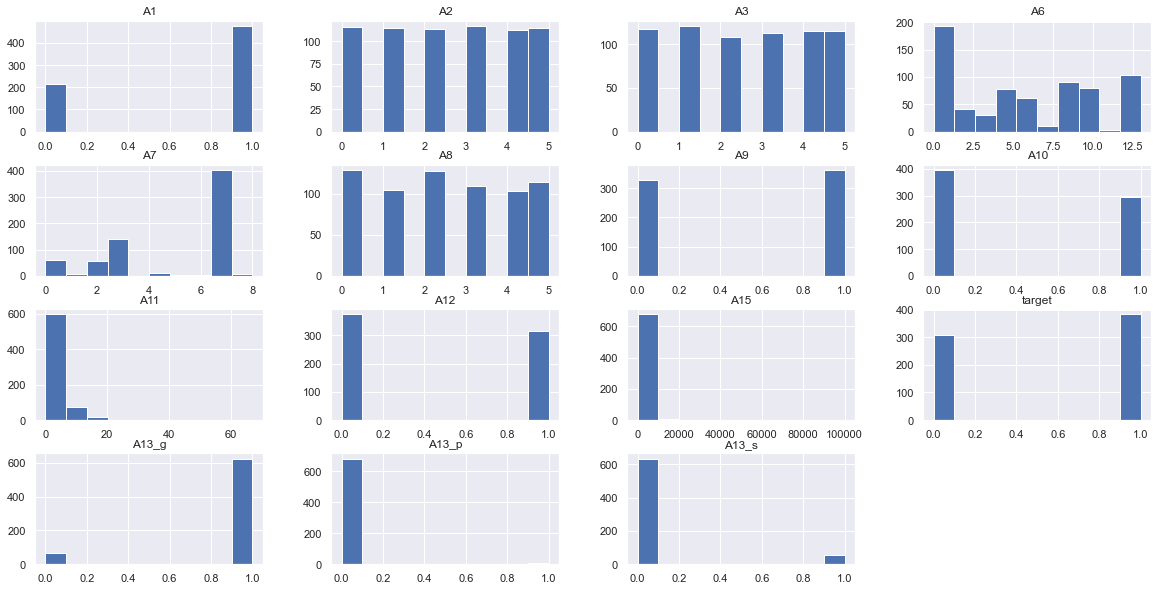

In [13]:
df.hist()
plt.gcf().set_size_inches(20, 10)

<AxesSubplot:xlabel='A10', ylabel='Count'>

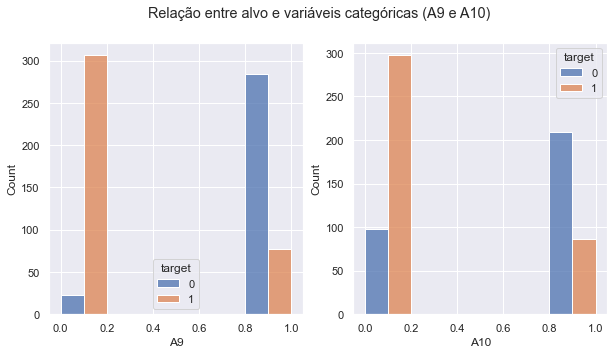

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Relação entre alvo e variáveis categóricas (A9 e A10)')

sns.histplot(df, x="A9", hue="target",  fill=True, multiple="dodge",binwidth=0.2, ax = ax[0])
sns.histplot(df, x="A10", hue="target", fill=True, multiple="dodge",binwidth=0.2, ax = ax[1])

<AxesSubplot:xlabel='A8', ylabel='Count'>

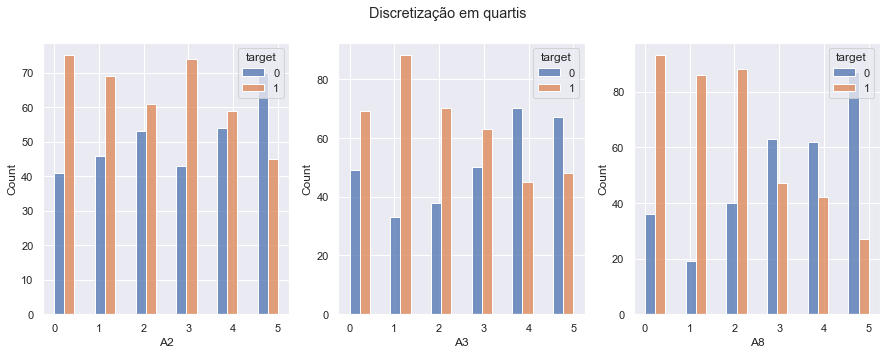

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Discretização em quartis')

sns.histplot(df, x="A2", hue="target", fill=True, multiple="dodge", ax = ax[0])
sns.histplot(df, x="A3", hue="target", fill=True, multiple="dodge", ax = ax[1])
sns.histplot(df, x="A8", hue="target", fill=True, multiple="dodge", ax = ax[2])

## 4 IMPLEMENTAÇÃO DO MODELO

### 4.1 Segmentação da Base de Dados

In [16]:
# Separando variáveis independentes da dependente (target)
x = df.drop("target", axis = 1)
y = df["target"]

# Separando bases de treinamento e teste em 50%
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.5, random_state = 42)

### 4.2 Treinamento do Modelo

In [17]:
# Configura variáveis
x_train_ = sm.add_constant(x_train)
x_test_ = sm.add_constant(x_test)

# Treina o modelo
reg_log = sm.GLM(y_train, x_train_, family = sm.families.Binomial())
reg_log = reg_log.fit()

# Resumo do modelo
print(reg_log.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 target   No. Observations:                  345
Model:                            GLM   Df Residuals:                      331
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -100.54
Date:                Wed, 21 Jul 2021   Deviance:                       201.07
Time:                        12:03:38   Pearson chi2:                     337.
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5136      0.587      4.285      0.0

### 4.3 Avaliação do Modelo

In [18]:
# Realizando previsão nas bases
y_pred_train = reg_log.predict(x_train_)
y_pred_test = reg_log.predict(x_test_)

# Calculando a ROC e o Gini - Treinamento
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train)
roc_auc_train = auc(fpr_train, tpr_train)

print("AUC - Treinamento : %f" % roc_auc_train)
print("Gini - Treinamento: ", round(2*roc_auc_train-1,2))
print("\n")

# Calculando a ROC e o Gini - Teste
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test)
roc_auc_test = auc(fpr_test, tpr_test)

print("AUC - Teste : %f" % roc_auc_test)
print("Gini - Teste: ", round(2*roc_auc_test-1,2))

AUC - Treinamento : 0.945193
Gini - Treinamento:  0.89


AUC - Teste : 0.911794
Gini - Teste:  0.82


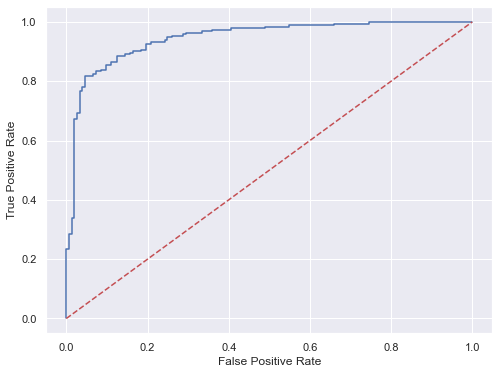

In [19]:
# Plotando a ROC (AUC) - Treinamento

roc_display = RocCurveDisplay(fpr=fpr_train, tpr=tpr_train).plot()
plt.plot([0, 1], [0, 1],'r--')
plt.gcf().set_size_inches(8, 6)

#### Otimização

Para otimizar o modelo, identifica-se o melhor ponto de corte do alvo para identificar cada categoria (**aprovado** ou **rejeitado**). Sendo assim, o ponto intersecção entre *True Positive Rate* e *False Positive Rate* é calculado de modo a obter um modelo mais efetivo.

In [20]:
i = np.arange(len(tpr_train))
roc_train = pd.DataFrame({'fpr' : pd.Series(fpr_train, index=i)
                    , 'tpr' : pd.Series(tpr_train, index = i)
                    , '1-fpr' : pd.Series(1-fpr_train, index = i)
                    , 'tf' : pd.Series(tpr_train - (1-fpr_train), index = i)
                    , 'thresholds' : pd.Series(thresholds_train, index = i)})


print(round(roc_train.loc[(roc_train.tf-0).abs().argsort()[:1]],3))
print("\n")
print("Ponto de corte otimizado: " + str(round(roc_train.loc[(roc_train.tf-0).abs().argsort()[:1]],3).iloc[0][4]))

      fpr    tpr  1-fpr    tf  thresholds
28  0.124  0.885  0.876  0.01       0.417


Ponto de corte otimizado: 0.417


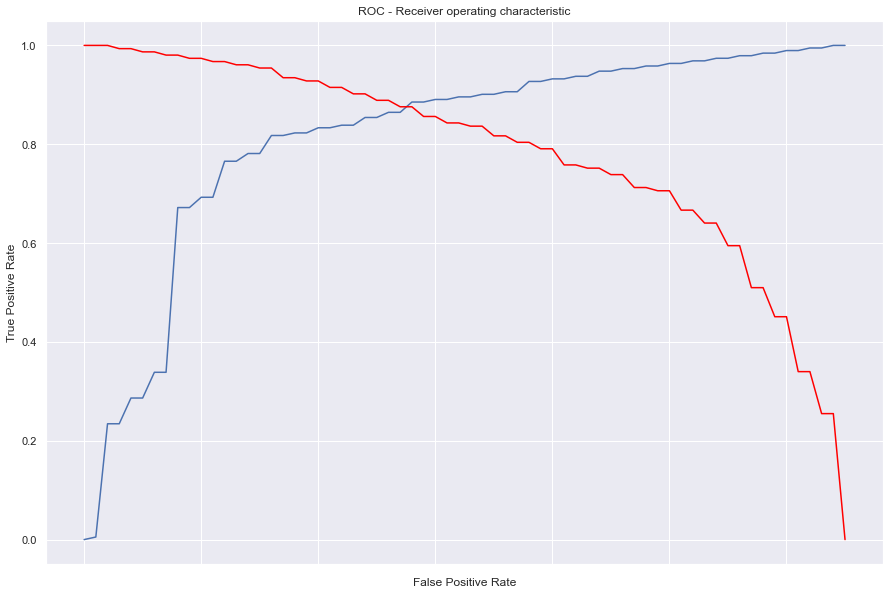

In [21]:
# False Positive Rate e True Positive Rate
fig, ax = plt.subplots()
plt.plot(roc_train['tpr'])
plt.plot(roc_train['1-fpr'], color = 'red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Receiver operating characteristic')
ax.set_xticklabels([]);
plt.gcf().set_size_inches(15, 10)

In [22]:
cutoff = round(roc_train.loc[(roc_train.tf-0).abs().argsort()[:1]],3).iloc[0][4]

# Criando os alvos binários para matriz de confusão
y_pred_train_bin = y_pred_train
y_pred_test_bin = y_pred_test

# Aplicando o corte para as probabilidades do treinamento
for score in range(0, len(y_pred_train-1)):
    if y_pred_train.iloc[score] >= cutoff:
        y_pred_train_bin.iloc[score] = 1
    else:
        y_pred_train_bin.iloc[score] = 0
        

# Aplicando o corte para as probabilidades do teste
for score in range(0, len(y_pred_test-1)):
    if y_pred_test.iloc[score] >= cutoff:
        y_pred_test_bin.iloc[score] = 1
    else:
        y_pred_test_bin.iloc[score] = 0

In [23]:
# Avaliando a matriz de confusão das bases

print("Avaliando a base de treinamento:")
print(confusion_matrix(y_train, y_pred_train_bin))
print("\n")
print("Avaliando a base de test:")
print(confusion_matrix(y_test, y_pred_test_bin))

Avaliando a base de treinamento:
[[134  19]
 [ 23 169]]


Avaliando a base de test:
[[132  22]
 [ 28 163]]


In [24]:
# Relatório de classificação

print(classification_report(y_test, y_pred_test_bin, target_names =['Rejeitado', 'Aprovado']))

              precision    recall  f1-score   support

   Rejeitado       0.82      0.86      0.84       154
    Aprovado       0.88      0.85      0.87       191

    accuracy                           0.86       345
   macro avg       0.85      0.86      0.85       345
weighted avg       0.86      0.86      0.86       345

